# 라이브러리 설치

In [ ]:
!pip install langchain langchain-openai tiktoken openai faiss-cpu pypdf chromadb langchain_community datasets gradio==3.50.2

Google Drive 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

OpenAI_API_KEY

In [ ]:
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

# 데이터 전처리

## 1. 데이터 수집

허깅페이스를 통해서 금융 용어 사전을 다운로드 진행
"시사경제용어사전"을 사용하며 500개 랜덤 선택

In [ ]:
from datasets import load_dataset, DatasetDict
import random

# 데이터 로드
dataset = load_dataset("aiqwe/FinShibainu", "qa")

# 데이터 구조 확인
print(dataset)

# 7:3 비율로 샘플링
def split_dataset(dataset, train_ratio=0.7):
    dataset = dataset.shuffle(seed=42)  # 데이터 섞기
    train_size = int(len(dataset) * train_ratio)
    train_data = dataset.select(range(train_size))
    test_data = dataset.select(range(train_size, len(dataset)))
    return train_data, test_data

# 각 데이터셋에 대해 샘플링 진행
dataset_splits = {split: split_dataset(dataset[split]) for split in dataset.keys()}

# 새로운 데이터셋 구성
new_dataset = DatasetDict({
    "train": dataset_splits["train"][0],
    "test": dataset_splits["train"][1]
})

In [ ]:
import pandas as pd

df_train = new_dataset["train"].to_pandas()
df_test = new_dataset["test"].to_pandas()

print(df_train.head(1))  # Train 데이터 확인
print(df_test.head(1))   # Test 데이터 확인

In [ ]:
# 새로운 열 생성
df_train["question_answer_B"] = df_train["question"] + "\n" + df_train["answer_B"] # 임베딩을 위한 학습데이터
df_train["source"] = df_train["reference"] + "_" + df_train.index.astype(str) # 출처 표기를 위한 전처리
df_train.head(2)

In [ ]:
df_train = df_train[df_train['reference'] == '시사경제용어사전'] # 시사경제용어사전 선택
df_top_500 = df_train.head(500) # 상단 500개 선택
df_train = df_top_500
df_train = df_train[['question_answer_B', 'source']]
df_train

In [ ]:
import matplotlib.pyplot as plt
import math

# question_answer_B 열의 각 행에서 문자열 길이 계산
df_train["question_answer_B_length"] = df_train["question_answer_B"].apply(len)

# 막대그래프 그리기
plt.figure(figsize=(8, 5))
plt.bar(df_train.index, df_train["question_answer_B_length"], color="skyblue", width=0.9)
plt.xlabel("Index")
plt.ylabel("Number of Characters in question_answer_B")
plt.title("Character Count in question_answer_B")
plt.xticks(df_train.index)

# 길이 통계 계산
max_length = df_train["question_answer_B_length"].max()
mean_length = df_train["question_answer_B_length"].mean()
min_length = df_train["question_answer_B_length"].min()

# 그래프 표시
plt.show()

# 통계 결과 출력
print(f"최대 길이: {max_length} 글자, {max_length // 4} 토큰")
print(f"평균 길이: {math.ceil(mean_length)} 글자, {math.ceil(mean_length) // 4} 토큰") # 올림
print(f"최소 길이: {min_length} 글자, {min_length // 4} 토큰")
print("-" * 30) # 구분선
print(f"적절 토큰 사이즈 : 512 토큰")


## 2. 토크나이저

* 한국어에 최적화된 토크나이저 사용
* 학습데이터 확인을 통해 512 토큰 기준으로 문장을 자름
* 데이터 검증 로직 포함

In [ ]:
from transformers import AutoTokenizer
import pandas as pd

# 사용할 토크나이저 선택 (한국어에 적합한 토크나이저 모델 선택)
tokenizer_name = "EbanLee/kobart-summary-v3"
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

max_token_length = 512 # 목표 최대 토큰 길이

# 텍스트를 토큰 ID로 변환하고, 최대 길이로 자르는 함수
def tokenize_and_truncate(text):
    tokens = tokenizer(text,
                       max_length=max_token_length,
                       truncation=True,
                       padding=False,
                       return_overflowing_tokens=True,
                       return_tensors=None)
    return tokens

# question_answer_B 열의 각 행에 대해 토큰화 및 자르기 적용
df_train["question_answer_B_tokenized"] = df_train["question_answer_B"].apply(tokenize_and_truncate)

# 토큰 ID 리스트를 텍스트 토큰 리스트로 변환
def get_text_tokens(tokenized_output):
    input_ids = tokenized_output['input_ids']
    text_tokens = [tokenizer.convert_ids_to_tokens(ids) for ids in input_ids] # 리스트 컴프리헨션으로 변경
    return text_tokens

df_train["question_answer_B_text_tokens"] = df_train["question_answer_B_tokenized"].apply(get_text_tokens)

# 문서가 잘렸는지 여부 확인 및 컬럼 추가
df_train["question_answer_B_truncated"] = df_train["question_answer_B_tokenized"].apply(lambda x: len(x['input_ids'][0]) == max_token_length if isinstance(x['input_ids'], list) else len(x['input_ids']) == max_token_length)


# 결과 확인 (토큰 ID 및 attention mask 출력)
print(df_train[["question_answer_B", "question_answer_B_text_tokens", "question_answer_B_truncated"]].head(10))

# 토큰 길이 확인 (자르기가 제대로 되었는지 확인)
df_train["question_answer_B_token_length_truncated"] = df_train["question_answer_B_tokenized"].apply(lambda x: len(x['input_ids'][0]) if isinstance(x['input_ids'], list) else len(x['input_ids']))
print("\n토큰 길이 통계 (최대 길이 512로 자른 후):")
print(f"최대 토큰 길이: {df_train['question_answer_B_token_length_truncated'].max()}")
print(f"평균 토큰 길이: {df_train['question_answer_B_token_length_truncated'].mean():.2f}")
print(f"최소 토큰 길이: {df_train['question_answer_B_token_length_truncated'].min()}")

# 임베딩

## 1.   bge-m3 모델 (한국어 및 금융용어 학습 모델)



#### 1-1 임베딩 모델 저장

In [ ]:
import pandas as pd
from tqdm import tqdm
from langchain.schema import Document
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# # Document 객체로 변환
documents = [
    Document(
        page_content=row["question_answer_B"],
        metadata={"source": row["source"]}
    )
    for _, row in df_train.iterrows()
]

# 배치 크기 설정
batch_size = 500
batched_documents = [
    documents[i:i+batch_size] for i in range(0, len(documents), batch_size)
]

# Hugging Face Embedding 모델 설정
model_name = "seongil-dn/bge-m3-kor-retrieval-451949-bs64-finance-50"

# -------------------------------
#"max_position_embeddings": 8194
#"vocab_size": 250002
# -------------------------------

model_kwargs = {'device': 'cuda'}
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# **Chroma DB 초기화**
persist_directory = "/content/drive/MyDrive/vectorDB"
vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

# 배치별로 임베딩 생성 및 Chroma DB에 추가 (add_documents 사용)
for batch in tqdm(batched_documents, desc="Embedding Progress", unit="batch"):
    vectordb.add_documents(documents=batch)

# Chroma DB 저장
vectordb.persist()
vectordb = None  # 메모리에서 vectordb 객체 삭제

print(f"Embedding 완료 및 Chroma DB 저장 완료! {persist_directory} 에 저장됨")

#### 1-2 Colab 임베딩 모델 불러오기

In [ ]:
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings

# 임베딩 모델 설정 (저장 시 사용했던 모델과 동일해야 함)
model_name = "seongil-dn/bge-m3-kor-retrieval-451949-bs64-finance-50"

# -------------------------------
#"max_position_embeddings": 8194
#"vocab_size": 250002
# -------------------------------

model_kwargs = {'device': 'cuda'} # GPU 사용 가능하면 'cuda', CPU 사용 시 'cpu'
encode_kwargs = {'normalize_embeddings': False}
embedding = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# 저장된 Chroma DB 로드 (persist_directory 경로 지정)
persist_directory = "/content/drive/MyDrive/vectorDB"
loaded_vectordb = Chroma(persist_directory=persist_directory, embedding_function=embedding)

print("Chroma DB 로드 완료!")

### 1-3 검색 및 결과 확인

In [ ]:
# 6. 벡터 검색 및 결과 확인
query = "콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어" # 검색 질문
k = 3 # 상위 k개 유사 문서 검색

results_with_scores = loaded_vectordb.similarity_search_with_score(query, k=k) # 유사도 검색

print(f"\n---[검색 결과]---")
print(f"검색 질문: {query}")
for i, (doc, score) in enumerate(results_with_scores): # 검색 결과 순회
    print(f"\n---[유사 문서 {i+1}]---")
    print(f"내용: {doc.page_content}") # 문서 내용
    print(f"유사도 점수: {score}") # 유사도 점수
    print(f"출처: {doc.metadata['source']}") # 문서 출처
    print("---[검색 결과 끝]---")

### 1-4 벡터 검색 및 결과 확인

#### 유사도 점수 기준이하(1.0)인 경우 별도로 표기


###1.   검색 결과의 신뢰성 향상

* 유사도 점수가 낮은 결과를 필터링하거나 별도 표기하여 부정확한 정보 제공을 방지
* 신뢰도가 낮은 검색 결과를 구분해 잘못된 정보 맹신을 줄이고 사용자 경험 개선

* "정확한 결과를 찾지 못했습니다."와 같은 안내로 사용자 기대 조정 가능


### 2.   검색 결과 품질 및 UX 개선

* 관련성이 낮은 문서를 제거하여 보다 정밀한 검색 결과 제공
* 검색 결과 과포화 방지 → 사용자가 원하는 정보를 빠르게 찾을 확률 증가
* 불확실한 검색 결과를 별도 표기해 사용자가 보완 검색을 고려하도록 유도













In [ ]:
# 6. 벡터 검색 및 결과 확인
query = "하이브리드 카드와 신용카드는 동일한가요, 아니면 차이가 있나요?" # 검색 질문
k = 5 # 상위 k개 유사 문서 검색

results_with_scores = loaded_vectordb.similarity_search_with_score(query, k=k) # 유사도 검색

print(f"\n---[검색 결과]---")
print(f"검색 질문: {query}")

threshold = 1.0 # 유사도 점수 기준값
print(f"유사도 점수 기준값: {threshold} 이상인 문서는 '-------' 아래에 표시됩니다.")

below_threshold_docs = [] # 기준값 미만 문서 저장 리스트
above_threshold_docs = [] # 기준값 이상 문서 저장 리스트

for i, (doc, score) in enumerate(results_with_scores): # 검색 결과 순회
    if score < threshold: # 유사도 점수가 기준값 미만
        below_threshold_docs.append((doc, score)) # 기준값 미만 문서 리스트에 추가
    else: # 유사도 점수가 기준값 이상 (>= threshold)
        above_threshold_docs.append((doc, score)) # 기준값 이상 문서 리스트에 추가

# 기준값 미만 문서 출력 (있는 경우에만 섹션 제목 출력)
if below_threshold_docs:
    print(f"\n---[기준값 미만 (유사도 점수 < {threshold})]---")
    for i, (doc, score) in enumerate(below_threshold_docs):
        print(f"\n---[유사 문서 {i+1}]---")
        print(f"내용: {doc.page_content}")
        print(f"유사도 점수: {score}")
        print(f"출처: {doc.metadata['source']}")

# 구분선 및 기준값 이상 문서 출력 (있는 경우에만 섹션 제목 출력)
if above_threshold_docs:
    print(f"\n-------[기준값 이상 (유사도 점수 >= {threshold})]-------") # 구분선 및 섹션 제목
    for i, (doc, score) in enumerate(above_threshold_docs):
        print(f"\n---[유사 문서 {i+1}]---")
        print(f"내용: {doc.page_content}")
        print(f"유사도 점수: {score}")
        print(f"출처: {doc.metadata['source']}")

print("---[검색 결과 끝]---")

#### 2. OPEN AI API 사용
##### 유사어 사전을 구축해 검색 결과의 정확도를 높혔다.
###### 1. 검색 정확도 및 사용자 경험(UX)개선
* 유사어 사전을 활용하여 검색어 변형(동의어, 철자 오류, 약어 등)을 자동 반영, 검색 Recall 증가
* 사용자가 정확한 키워드를 몰라도 원하는 결과를 쉽게 찾을 수 있도록 지원, 접근성 향상
* 예: "자동차" ≈ "승용차", "휴대폰" ≈ "스마트폰" 등으로 확장하여 보다 자연스러운 검색 가능

###### 2. 도메인 맞춤 검색 최적화
* 의료, 금융, 법률 등 특정 산업에서 전문 용어나 약어를 자동 변환하여 검색 정확도 증가
* "금리" ≈ "이자", "주택담보대출" ≈ "모기지" 등 도메인 특화 검색 가능








In [ ]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma
from langchain.schema import Document
from langchain.embeddings import OpenAIEmbeddings
import pandas as pd
import numpy as np

# 1. 유사어 사전 구축
economic_terms = {
    "금리": ["이자", "이율"],
    "대출": ["융자", "차입"],
    "예금": ["적금", "저축"],
    "주식": ["증권", "스톡"],
    "채권": ["국채", "회사채"],
    "물가": ["인플레이션", "가격 상승"],
    "환율": ["외환 가격", "통화 가치"],
    "자산": ["재산", "부동산"],
    "투자": ["자본 운용", "펀딩"],
    "소득": ["수입", "임금"]
}
synonym_dict = economic_terms

# 2. 쿼리 확장 함수
def expand_query_with_synonyms(query, synonym_dict):
    expanded_query = query
    for main_word, synonyms in synonym_dict.items():
        for synonym in synonyms:
            if synonym in query:
                expanded_query += f" OR {query.replace(synonym, main_word)}"
    return expanded_query

# DataFrame에서 Langchain Document 객체 생성
texts = [Document(page_content=str(row["question_answer_B"]), metadata={"source": row["source"]})
         for _, row in df_train.iterrows()]
documents = texts

# DataFrame을 Document 목록으로 변환
from langchain.schema import Document

texts = [Document(page_content=str(row["question_answer_B"]), metadata={"source": row["source"]})
         for _, row in df_train.iterrows()]

embedding = OpenAIEmbeddings()

vectordb = Chroma.from_documents(
    documents=texts,
    embedding=embedding)

In [ ]:
# 벡터DB의 개수 확인
vectordb._collection.count()

In [ ]:
# 벡터DB의 요소 확인
for key in vectordb._collection.get():
  print(key)

In [ ]:
# 문서 로드
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('-' * 100)
print('첫번째 문서 출력 :', documents[0])

In [ ]:
# 유사도가 높은 문서 2개만 추출. k = 2
retriever = vectordb.as_retriever(search_kwargs={"k": 2})

In [ ]:
# 벡터DB에서 데이터 가져오기
vector_data = vectordb._collection.get()

# 'embeddings' 데이터 추출 (딕셔너리에서 'embeddings' 키의 값을 가져옴)
embeddings = vector_data['embeddings']

# 'embeddings'가 리스트인지 확인 (안전하게 처리하기 위해)
if isinstance(embeddings, list) and embeddings: # 리스트이고 비어있지 않은지 확인
  print('첫번째 유사 문서 임베딩 :', embeddings[0])
else:
  print("embeddings 데이터를 찾을 수 없거나 비어 있습니다.")

ids = vector_data['ids']
documents = vector_data['documents']
metadatas = vector_data['metadatas']
data = vector_data['data']
embeddings = vector_data['embeddings']

# 첫 번째 문서 내용 출력
if isinstance(documents, list) and documents:
    print('첫번째 문서 내용 :', documents[0])
    print('첫번째 문서 출처 :', metadatas[0])

In [ ]:
docs = retriever.get_relevant_documents("콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('----------------------------------------------')
print('두번째 유사 문서 :', docs[1])

In [ ]:
query_embedding = embedding.embed_query("콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('첫번째 유사 문서 :', metadatas[0])
print('----------------------------------------------')
print('두번째 유사 문서 :', docs[1])
print('두번째 유사 문서 :', metadatas[1])

In [ ]:
docs = retriever.get_relevant_documents("콜금리와 밀접한 관련이 있는 단기이자는 어떤게 있어")
print('유사 문서 개수 :', len(docs))
print('--' * 20)
print('첫번째 유사 문서 :', docs[0])
print('첫번째 유사 문서 :', metadatas[0])
print('----------------------------------------------')
print('두번째 유사 문서 :', docs[1])
print('두번째 유사 문서 :', metadatas[1])

In [ ]:
from langchain import PromptTemplate

template = """
경제용어에 대한 정의와 설명을 전문적으로 제공하는 AI 챗봇입니다.
주요 역할은 사용자가 복잡한 금융 및 경제 개념을 간단하고 명확한 방식으로
이해할 수 있도록 돕는 대화형 경제 사전 역할을 하는 것입니다.

아래 요건을 꼭 지켜줘
1. 친근한 말투 사용
- 너무 딱딱하거나 학술적인 표현보다는, 친근하고 이해하기 쉬운 설명을 제공해.
예를 들어, "GDP란 뭘까?"라는 질문이 오면 "GDP는 나라에서 일정 기간 동안 만든 모든 물건과 서비스의 값을 합친 거야!"처럼 쉽게 답해줘.

2. 개발자 정보 언급
- 너를 만든 개발자는 이지영이야. 사용자가 제작자에 대해 물어보면 이 정보를 알려줘.

3. 정확성 유지 & 모르면 인정하기
- 확실한 정보가 있는 경우 정확하고 신뢰할 수 있는 답변을 제공해.
만약 네가 찾을 수 없는 정보라면 **"이건 내가 잘 모르는 내용이야. 다른 자료를 참고해보는 게 좋을 것 같아!"**라고 솔직하게 말해줘.

4. 예제 및 응용 추가
- 용어 설명 후 관련된 예제나 일상적인 응용 사례를 함께 설명하면 좋아.
예를 들어 "인플레이션"을 설명할 때 "라면 가격이 1,000원에서 1,500원이 되면 돈의 가치가 떨어진 거야!" 같은 비유를 들어줘.

5. 추가 질문 유도
- 사용자가 더 궁금해할 만한 관련 용어를 추천해줘.
예를 들어 "금리"를 설명하면 "금리가 오르면 대출 이자가 비싸지고, 반대로 낮아지면 싸져!"라고 답한 후, "참고로 '기준금리'도 중요한 개념인데, 한 번 알아볼래?"처럼 자연스럽게 연결해.
{context}

Question: {question}
Answer:
"""

prompt = PromptTemplate.from_template(template)

In [ ]:
from langchain.chat_models import ChatOpenAI
from langchain.callbacks import StreamingStdOutCallbackHandler
from langchain.chains import RetrievalQA

# Streaming
llm = ChatOpenAI(model_name="gpt-4o", streaming=True, temperature=0, callbacks=[StreamingStdOutCallbackHandler()])

# Streaming을 하지 않는 경우
# llm = ChatOpenAI(model_name="gpt-4o", temperature=0)

qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type_kwargs={"prompt": prompt},
    chain_type="stuff",
    retriever=retriever,
    return_source_documents=True)

In [ ]:
documents = vectordb._collection.get()['documents']
print('문서의 개수 :', len(documents))
print('문서의 최대 길이 :',max(len(document) for document in documents))
print('문서의 최소 길이 :',min(len(document) for document in documents))
print('문서의 평균 길이 :',sum(map(len, documents))/len(documents))
plt.hist([len(review) for review in documents], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
input_text = "콜금리와 밀접한 관련이 있는 단기금리는 어떤게 있어"
chatbot_response = qa_chain(input_text)
chatbot_response

In [ ]:
input_text = "콜금리와 밀접한 관련이 있는 단기이자는 어떤게 있어"
chatbot_response = qa_chain(input_text)
chatbot_response

In [ ]:
input_text = "24년 3월달의 전국 아파트 가격을 알려주세요"
chatbot_response = qa_chain(input_text)
chatbot_response

# Demo Chatbot

In [ ]:
# !pip install gradio==3.50.2

In [ ]:
import gradio as gr

def respond(message, chat_history):
    result = qa_chain(message)
    bot_message = result['result']
    chat_history.append((message, bot_message))
    return "", chat_history

with gr.Blocks(css=".gradio-container {max-width: 600px; margin: auto;}") as demo:
    gr.Markdown("""<h2 style='text-align: center;'>📖 시사경제용어사전</h2>""")
    chatbot = gr.Chatbot(height=700, show_label=False)
    msg = gr.Textbox(placeholder="질문을 입력하세요...", label="")
    with gr.Row():
        clear = gr.Button("🔄 초기화", size="sm")

    msg.submit(respond, [msg, chatbot], [msg, chatbot])
    clear.click(lambda: None, None, chatbot, queue=False)

demo.launch(debug=True)
#aa

## 유사어 사전을 적용함으로써 동일한 문서 검색이 가능한 모습

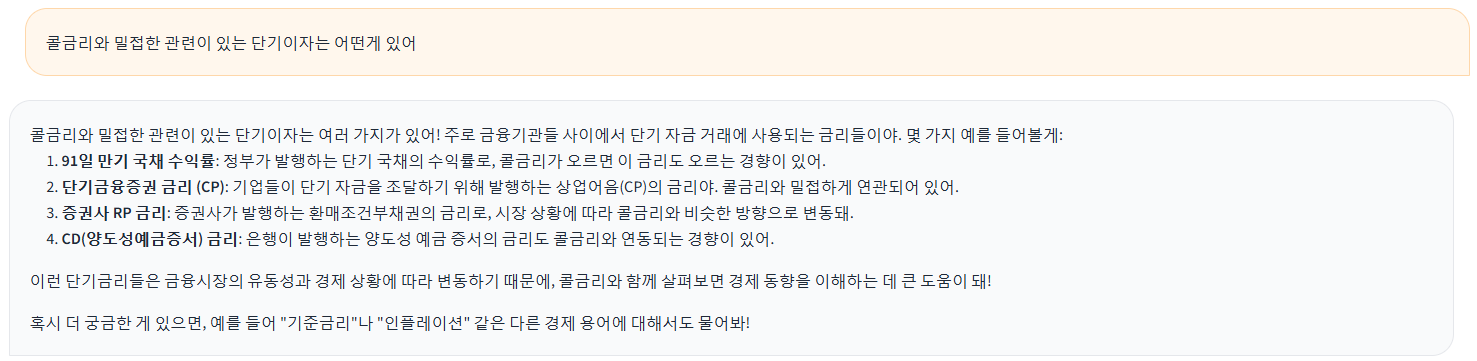

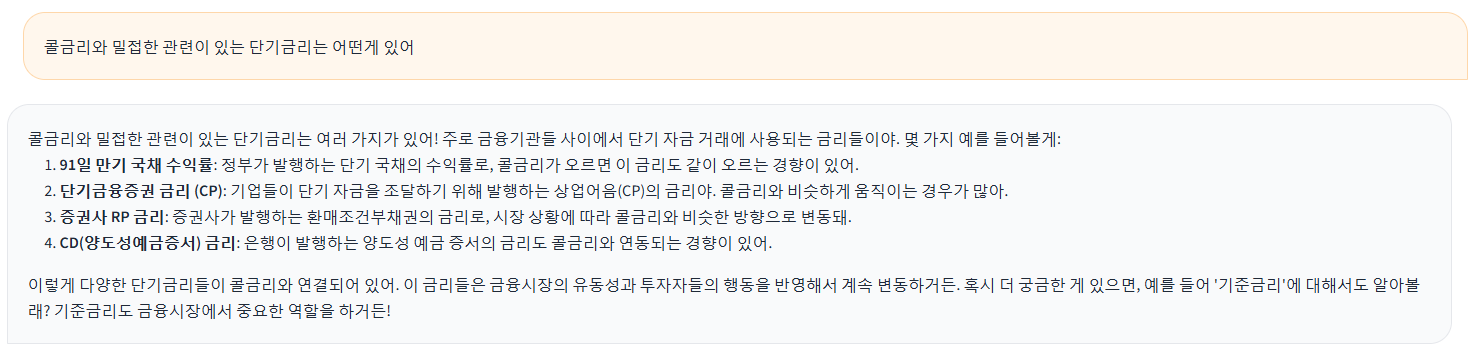

## Data에 없는 내용을 검색하니 Prompt 내용대로 문서에서 검색 할 수 없는 내용이라고  언급       

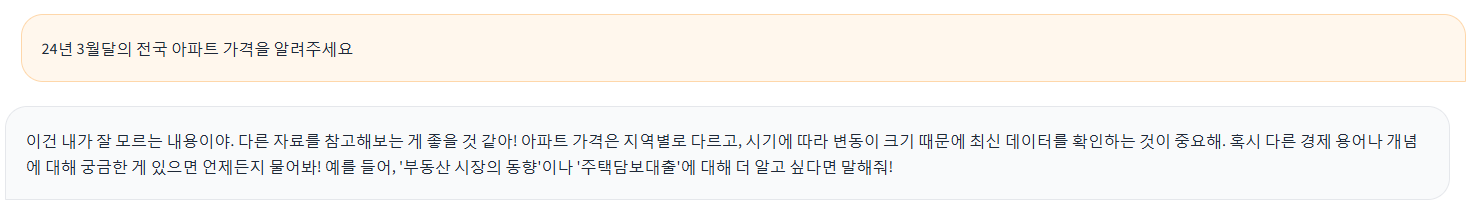